Борисенко Дмитрий Антонович РИ-230945

# Imports/utils

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
# Функция для генерации синтетических данных
def generate_synthetic_data(n_train=1000, n_val=200, n_features=10, noise_std=0.1, seed=42):
    torch.manual_seed(seed)
    true_weights = torch.randn(n_features, 1)
    true_bias = torch.randn(1)

    X_train = torch.randn(n_train, n_features)
    y_train = X_train @ true_weights + true_bias
    y_train += noise_std * torch.randn_like(y_train)

    X_val = torch.randn(n_val, n_features)
    y_val = X_val @ true_weights + true_bias
    y_val += noise_std * torch.randn_like(y_val)

    return X_train, y_train, X_val, y_val

# Задание 2: Работа с датасетами

2.1 Кастомный Dataset класс (15 баллов)

Создайте кастомный класс датасета для работы с CSV файлами:
- Загрузка данных из файла
- Предобработка (нормализация, кодирование категорий)
- Поддержка различных форматов данных (категориальные, числовые, бинарные)

In [50]:
class CSVDataset(Dataset):
    def __init__(self, csv_path, target_column, categorical_cols=None,
                 binary_cols=None, normalize=True):
        """
        csv_path: путь к CSV-файлу
        target_column: имя колонки с таргетом
        categorical_cols: список категориальных колонок
        binary_cols: список бинарных колонок
        normalize: нужно ли нормализовать числовые колонки
        """
        self.df = pd.read_csv(csv_path)
        self.target_column = target_column

        self.y = self.df[target_column].values
        self.X = self.df.drop(columns=[target_column])

        self.categorical_cols = categorical_cols or []
        self.binary_cols = binary_cols or []
        self.numerical_cols = [col for col in self.X.columns
                               if col not in self.categorical_cols + self.binary_cols]

        # Предобработка
        self._encode_target()
        self._process_features(normalize)

        # Перевод в тензоры
        self.X = torch.tensor(self.X.values, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long if self.is_classification else torch.float32)

    def _encode_target(self):
        if self.y.dtype.kind in 'OUS':  # object, unicode — строковая классификация
            self.encoder = LabelEncoder()
            self.y = self.encoder.fit_transform(self.y)
            self.is_classification = True
        else:
            self.is_classification = False  # регрессия

    def _process_features(self, normalize):
        # 1. Категориальные переменные — one-hot
        if self.categorical_cols:
            one_hot = pd.get_dummies(self.X[self.categorical_cols], drop_first=True)
            self.X = self.X.drop(columns=self.categorical_cols)
            self.X = pd.concat([self.X, one_hot], axis=1)

        # 2. Бинарные — преобразуем в 0/1 если строковые
        for col in self.binary_cols:
            if self.X[col].dtype == 'object':
                self.X[col] = self.X[col].map({self.X[col].unique()[0]: 0, self.X[col].unique()[1]: 1})
            self.X[col] = self.X[col].astype(int)

        # 3. Числовые — нормализуем (StandardScaler)
        if normalize and self.numerical_cols:
            scaler = StandardScaler()
            self.X[self.numerical_cols] = scaler.fit_transform(self.X[self.numerical_cols])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [51]:
logreg_dataset = CSVDataset(
    csv_path='iris.csv',
    target_column='species',
    binary_cols=None,
    normalize=True
)
linreg_dataset = CSVDataset(
    csv_path='SAT_GPA.csv',
    target_column='GPA',
    normalize=True
)

# Задание 1: Модификация существующих моделей

1.1 Расширение линейной регрессии

Модифицируйте существующую линейную регрессию:
- Добавьте L1 и L2 регуляризацию
- Добавьте early stopping

In [52]:
class LinearRegression(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.linear(x)

In [75]:
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                regularization_type=None, early_stopping_patience=5,
                lambda_reg=0.01, epochs=20):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()

        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # L1 regularization
        if regularization_type == 'L1':
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += lambda_reg * l1_norm

        # L2 regularization
        elif regularization_type == 'L2':
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss += lambda_reg * l2_norm

        loss.backward()
        optimizer.step()

        # Проверка на валидации
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

        print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
            best_model_state = model.state_dict()  # сохранить лучшую модель
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)  # восстановить лучшую модель
                break
    return best_val_loss

In [76]:
X, y = linreg_dataset.X, linreg_dataset.y

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression(in_features=X.shape[1])
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

loss = train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val,
            regularization_type='L2',
            lambda_reg=1e-5, early_stopping_patience=10)

Epoch 1, Train Loss: 15.8556, Val Loss: 15.5982
Epoch 2, Train Loss: 15.2360, Val Loss: 14.9837
Epoch 3, Train Loss: 14.6408, Val Loss: 14.3935
Epoch 4, Train Loss: 14.0690, Val Loss: 13.8265
Epoch 5, Train Loss: 13.5196, Val Loss: 13.2819
Epoch 6, Train Loss: 12.9917, Val Loss: 12.7587
Epoch 7, Train Loss: 12.4846, Val Loss: 12.2562
Epoch 8, Train Loss: 11.9974, Val Loss: 11.7735
Epoch 9, Train Loss: 11.5293, Val Loss: 11.3098
Epoch 10, Train Loss: 11.0796, Val Loss: 10.8644
Epoch 11, Train Loss: 10.6476, Val Loss: 10.4366
Epoch 12, Train Loss: 10.2325, Val Loss: 10.0257
Epoch 13, Train Loss: 9.8337, Val Loss: 9.6309
Epoch 14, Train Loss: 9.4505, Val Loss: 9.2518
Epoch 15, Train Loss: 9.0824, Val Loss: 8.8876
Epoch 16, Train Loss: 8.7287, Val Loss: 8.5378
Epoch 17, Train Loss: 8.3890, Val Loss: 8.2018
Epoch 18, Train Loss: 8.0625, Val Loss: 7.8790
Epoch 19, Train Loss: 7.7489, Val Loss: 7.5691
Epoch 20, Train Loss: 7.4476, Val Loss: 7.2713


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([67])) that is different to the input size (torch.Size([67, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1.2 Расширение логистической регрессии

Модифицируйте существующую логистическую регрессию:
- Добавьте поддержку многоклассовой классификации
- Реализуйте метрики: precision, recall, F1-score, ROC-AUC
- Добавьте визуализацию confusion matrix

In [55]:
class LogisticRegression(nn.Module):
    def __init__(self, in_features, num_classes=2):
        super().__init__()
        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.linear(x)

Функция для вычисления и печати метрик

In [56]:
def compute_metrics(y_true, y_pred, y_prob=None, average='macro'):
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

    if y_prob is not None:
        try:
            roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average=average)
            print(f"ROC-AUC:   {roc_auc:.4f}")
        except Exception as e:
            print("ROC-AUC calculation error:", e)

Визуализация confusion matrix

In [57]:
def draw_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [58]:
# Генерация данныx
def generate_data(n_samples=1500, n_features=10, n_classes=3, seed=42):
    X, y = make_classification(n_samples=n_samples,
                               n_features=n_features,
                               n_informative=6,
                               n_redundant=0,
                               n_classes=n_classes,
                               n_clusters_per_class=1,
                               random_state=seed)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    return X, y

In [59]:
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=50):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(X_train)
        loss = criterion(logits, y_train)
        loss.backward()
        optimizer.step()

Precision: 0.9024
Recall:    0.9000
F1-score:  0.8997
ROC-AUC:   0.9600


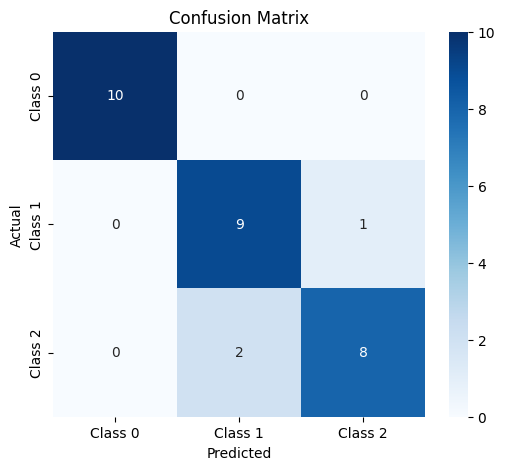

In [60]:
X, y = logreg_dataset.X, logreg_dataset.y
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(logreg_dataset.encoder.classes_)
in_features=X.shape[1]

model = LogisticRegression(in_features=in_features, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr)

train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val)
model.eval()
with torch.no_grad():
    val_logits = model(X_val)
    val_probs = F.softmax(val_logits, dim=1).numpy()
    val_preds = torch.argmax(val_logits, dim=1).numpy()
    y_true = y_val.numpy()

# Метрики и визуализация
compute_metrics(y_true, val_preds, val_probs, average='macro')
draw_confusion_matrix(y_true, val_preds, class_names=[f"Class {i}" for i in range(num_classes)])

# Задание 3: Эксперименты и анализ

3.1 Исследование гиперпараметров (10 баллов)

Проведите эксперименты с различными:
- Скоростями обучения (learning rate)
- Размерами батчей
- Оптимизаторами (SGD, Adam, RMSprop)

Визуализируйте результаты в виде графиков или таблиц

In [79]:
def train_model1(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                regularization_type=None, early_stopping_patience=5,
                lambda_reg=0.01, epochs=20):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()

        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # L1 regularization
        if regularization_type == 'L1':
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += lambda_reg * l1_norm

        # L2 regularization
        elif regularization_type == 'L2':
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss += lambda_reg * l2_norm

        loss.backward()
        optimizer.step()

        # Проверка на валидации
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
            best_model_state = model.state_dict()  # сохранить лучшую модель
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                model.load_state_dict(best_model_state)  # восстановить лучшую модель
                break
    return best_val_loss

In [83]:
def run_experiments():
    # Гиперпараметры для эксперимента
    learning_rates = [0.001, 0.01, 0.1]
    batch_sizes = [16, 32, 64]
    optimizers = ['SGD', 'Adam', 'RMSprop']
    results = []
    X, y = linreg_dataset.X, linreg_dataset.y

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    for lr in learning_rates:
        for bs in batch_sizes:
            for opt_name in optimizers:
                # Инициализируем модель
                model = LinearRegression(in_features=X.shape[1])
                criterion = nn.MSELoss()

                # Выбираем оптимизатор
                if opt_name == 'SGD':
                    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
                elif opt_name == 'Adam':
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                else:  # RMSprop
                    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)


                val_loss = train_model1(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                            regularization_type='L2',
                            lambda_reg=1e-5, early_stopping_patience=10, epochs=10)
                results.append({
                      'learning_rate': lr,
                      'batch_size': bs,
                      'optimizer': opt_name,
                      'val_loss': val_loss
                  })

    df = pd.DataFrame(results)
    return df


In [81]:
def plot_results(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df, x='learning_rate', y='val_loss', hue='optimizer', style='batch_size', markers=True)
    plt.title('Validation Loss vs Learning Rate')
    plt.xscale('log')
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([67])) that is different to the input size (torch.Size([67, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


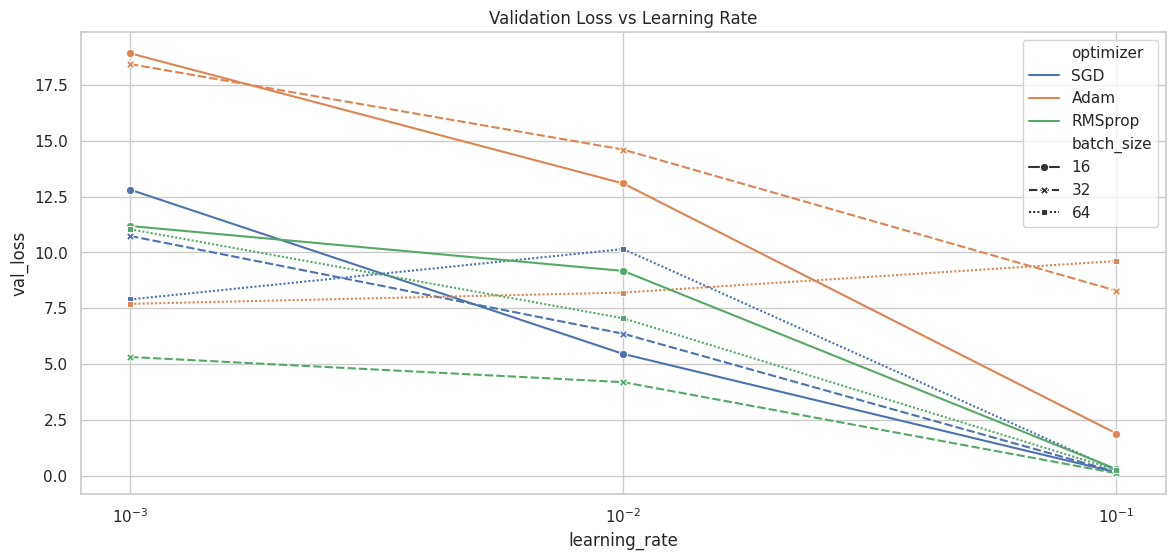

In [84]:
df_reg = run_experiments()
plot_results(df_reg)